# Decision Tree
## Research Question: "Predict whether a stop and search will conclude in police action".

#### In this notebook we attempt to answer the research question using the data set (https://www.kaggle.com/sohier/london-police-records?select=london-stop-and-search.csv). Specifically, we will attempt to answer it by using K-nearest Neighbor to classify the data points on the target ("Outcome" of the stop and search).

In [104]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import util
import util_smote as usm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline


## Cleaning the Data set

In [39]:
data = pd.read_csv("data.csv")

# data = data.dropna()
data = util.data_cleaner(data)
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 165651 entries, 0 to 302621
Data columns (total 10 columns):
 #   Column                     Non-Null Count   Dtype              
---  ------                     --------------   -----              
 0   Type                       165651 non-null  object             
 1   Date                       165651 non-null  datetime64[ns, UTC]
 2   Latitude                   165651 non-null  float64            
 3   Longitude                  165651 non-null  float64            
 4   Gender                     165651 non-null  object             
 5   Age range                  165651 non-null  object             
 6   Officer-defined ethnicity  165651 non-null  object             
 7   Legislation                165651 non-null  object             
 8   Object of search           165651 non-null  object             
 9   Outcome                    165651 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(2), object(7)
memory 

## Encoding Values

In [40]:
data_encoded, encoders = util.data_encoder(data)
data_encoded.head()

,Type,Date,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,Outcome
0,1,0,51.512286,-0.114491,1,1,0,4,8,6
1,1,0,51.512286,-0.114491,1,1,0,4,8,6
2,1,1,51.512286,-0.114491,1,1,4,4,8,6
4,0,2,51.512286,-0.114491,1,1,4,4,8,6
5,1,3,51.512286,-0.114491,1,1,0,3,3,2


## Split the data into train and test

In [41]:
# Split into features and target
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=10)

## Train the Decision Tree

In [42]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

Training Score: 0.9880169031089647
Testing Score: 0.537532824243156

 Confusion Matrix


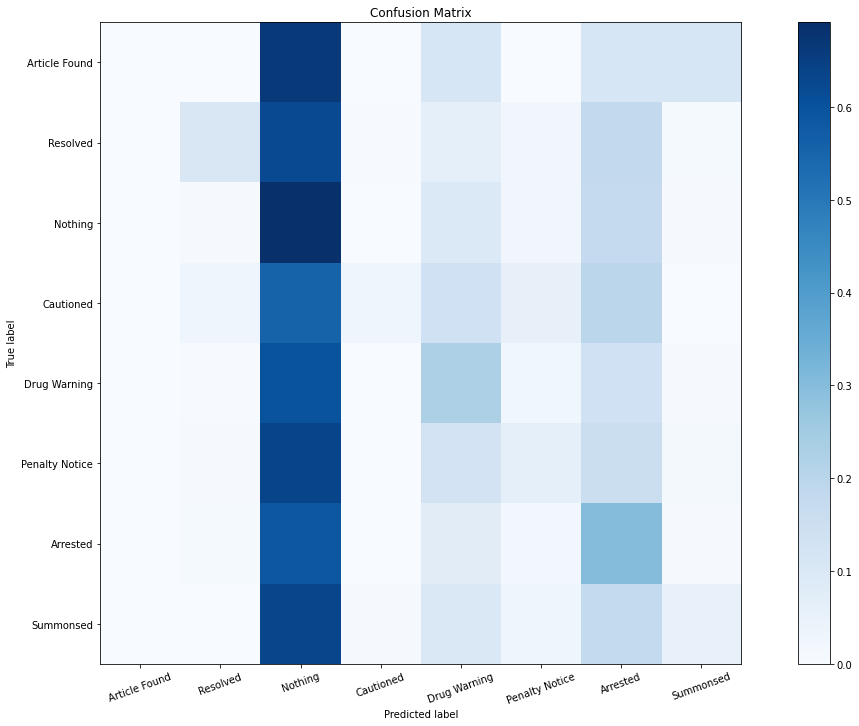

In [43]:
print(f"Training Score: {tree.score(X_train, y_train)}")
print(f"Testing Score: {tree.score(X_test, y_test)}")
print("\n Confusion Matrix")
y_predictions = tree.predict(X_test)
util.confusion_plot(y_test=y_test, y_predictions=y_predictions)

Large discrepency between the training score and testing score indicates large overfitting of the data, I will prune the data.

## Prune and visualisation

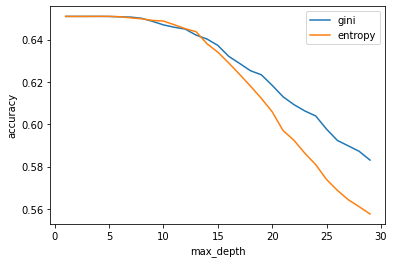

In [44]:
#Simple function to run our model using different values for max_depth (from 1 to 30) and visualise its results to see how the accuracy differs for each value.
#Visualisation technique from: https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1,30):
 dtree = DecisionTreeClassifier(criterion='gini', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_gini.append(accuracy_score(y_test, pred))
 ####
 dtree = DecisionTreeClassifier(criterion = 'entropy', max_depth=i)
 dtree.fit(X_train, y_train)
 pred = dtree.predict(X_test)
 acc_entropy.append(accuracy_score(y_test, pred))
 ####
 max_depth.append(i)
d = pd.DataFrame({'acc_gini':pd.Series(acc_gini), 
 'acc_entropy':pd.Series(acc_entropy),
 'max_depth':pd.Series(max_depth)})
# visualizing changes in parameters
plt.plot('max_depth','acc_gini', data=d, label='gini')
plt.plot('max_depth','acc_entropy', data=d, label='entropy')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()

It seems like in this scenario gini and entropy both work best for smaller trees, but gini does a better job for longer trees. So let’s draw the tree with max_depth=5 and criterion=entropy to see how it looks like.

In [69]:
ptree = DecisionTreeClassifier(criterion='gini', max_depth=5)
ptree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

Training Score: 0.6550332025354664
Testing Score: 0.6509915185174007

 Confusion Matrix


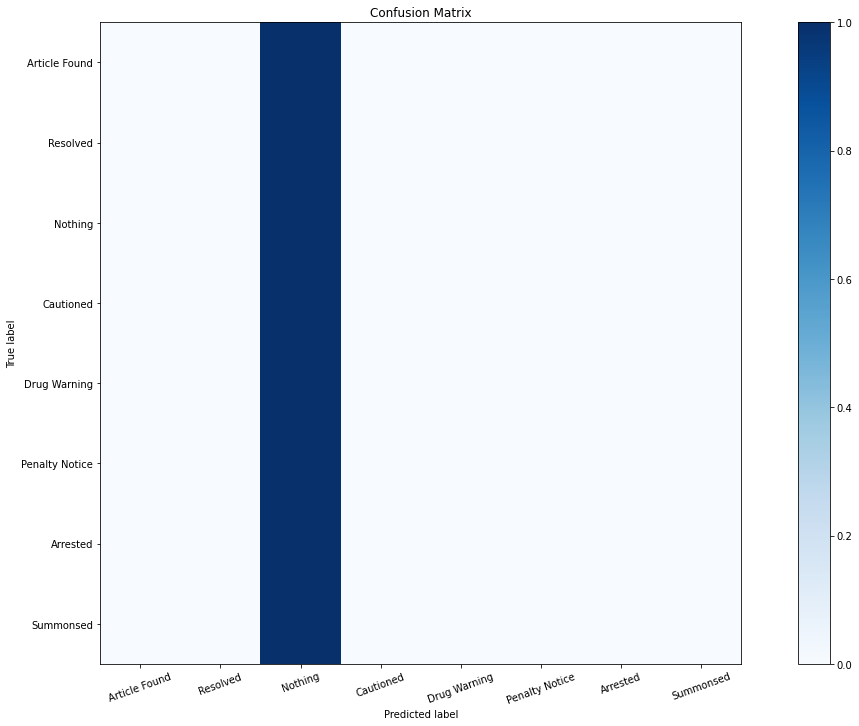

In [70]:
print(f"Training Score: {ptree.score(X_train, y_train)}")
print(f"Testing Score: {ptree.score(X_test, y_test)}")
print("\n Confusion Matrix")
y_predictions = ptree.predict(X_test)
util.confusion_plot(y_test=y_test, y_predictions=y_predictions)

Better accuracy score but the Decision Tree appears to be very biased towards predicting Nothing. I will try to preprocess the features.

## Preprocessing

In [62]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X_train)

StandardScaler()

In [63]:
#Preproccesing technique from lecture 2 to normalise the data
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

Training Score: 0.5434726833685481
Testing Score: 0.5444145966013704

 Confusion Matrix


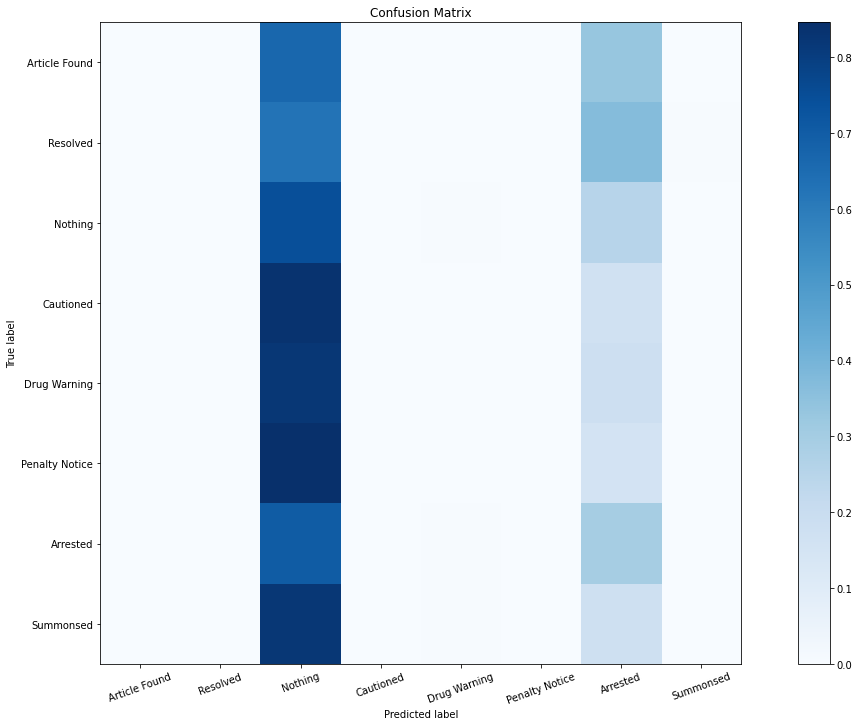

In [71]:
tree_std = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree_std.fit(X_train, y_train)
print(f"Training Score: {tree.score(X_train, y_train)}")
print(f"Testing Score: {tree.score(X_test, y_test)}")
print("\n Confusion Matrix")
y_predictions = tree.predict(X_test)
util.confusion_plot(y_test=y_test, y_predictions=y_predictions)

This produces a sligthly more balanced confusion matrix, but at the cost of the accuracy of the model. I will try K-Fold instead.

## Training Using K-Fold Cross Validation

In [73]:
#Split the data, into a small testing set (test size 0.1), and large training set (that will be passed into K-cross validation)
X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(features, target, test_size=0.1, random_state=10)

#Merging X_train and y_train into a single dataframe for K-cross validation utility function
#Merging technique from: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
frames_2 = [X_train_k, y_train_k]
k_fold_data = pd.concat(frames_2, axis=1)

#K-cross validation on k_fold_binary_data 
tree_kfold = DecisionTreeClassifier(criterion='gini', max_depth=5)
util.k_fold_train(model=tree_kfold, data=k_fold_data)

🚫 WARNING 🚫: this function will take time to process.
 
Fold #1, Training Size: 119268, Validation Size: 29817
Training Score: 0.6540815642083375
Testig Score: 0.6540815642083375


Fold #2, Training Size: 119268, Validation Size: 29817
Training Score: 0.6554314652714894
Testig Score: 0.6554314652714894


Fold #3, Training Size: 119268, Validation Size: 29817
Training Score: 0.653905490156622
Testig Score: 0.653905490156622


Fold #4, Training Size: 119268, Validation Size: 29817
Training Score: 0.6546349397994433
Testig Score: 0.6546349397994433


Fold #5, Training Size: 119268, Validation Size: 29817
Training Score: 0.6549870879028742
Testig Score: 0.6549870879028742




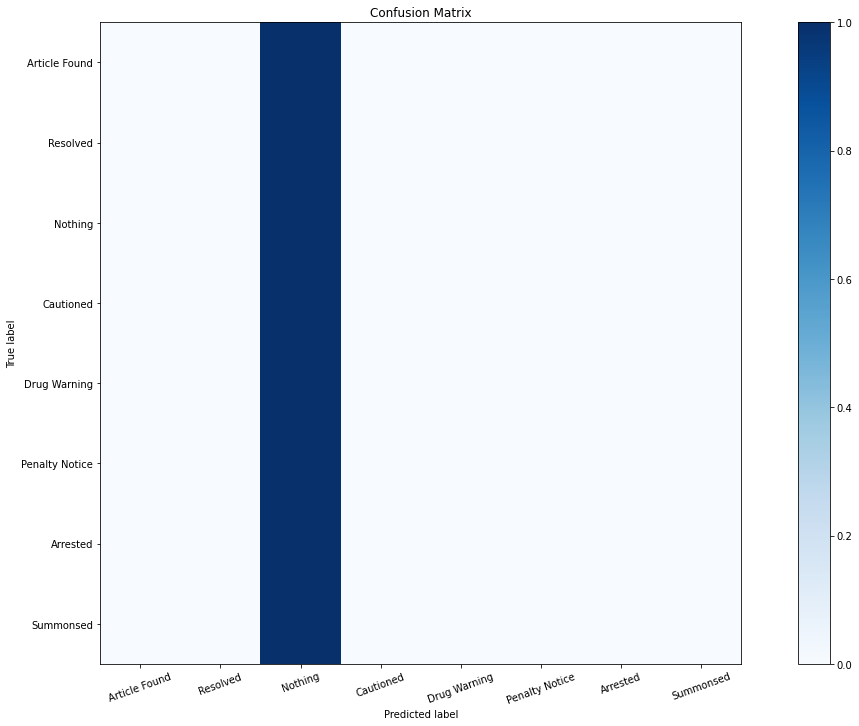

In [68]:
y_predict_k = tree_kfold.predict(X_test_k)
util.confusion_plot(y_test=y_test_k, y_predictions=y_predict_k)

## Using SMOTE
We use SMOTE to even out the unbalanced datasetm should I use the preprocessed data?

Class 0: 0.02%     (41)
Class 1: 0.68%     (1121)
Class 2: 65.41%     (108353)
Class 3: 0.1%     (167)
Class 4: 10.74%     (17788)
Class 5: 2.31%     (3824)
Class 6: 19.96%     (33067)
Class 7: 0.78%     (1290)
Total: 165651


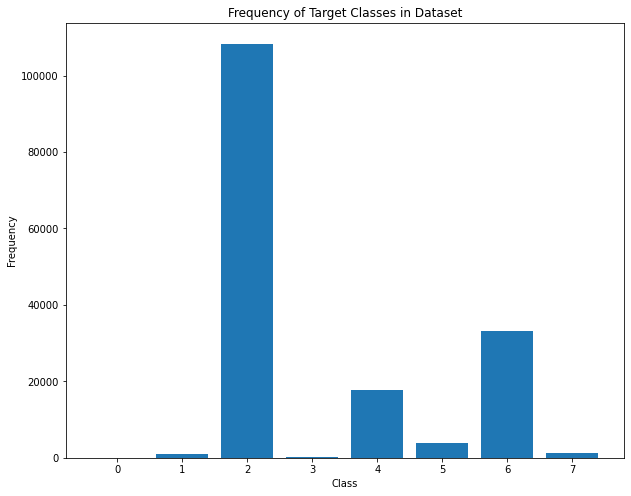

In [78]:
#The frequencies of each class in the dataset
usm.display_frequencies(data_encoded["Outcome"])

In [89]:
#Train/test split data_encoded
target = data_encoded["Outcome"]
features = data_encoded.drop('Outcome', axis=1)
X_train2, X_test2, y_train2, y_test2 = train_test_split(features, target, test_size=0.2, random_state=10)

Class 0: 12.5%     (86784)
Class 1: 12.5%     (86784)
Class 2: 12.5%     (86784)
Class 3: 12.5%     (86784)
Class 4: 12.5%     (86784)
Class 5: 12.5%     (86784)
Class 6: 12.5%     (86784)
Class 7: 12.5%     (86784)
Total: 694272


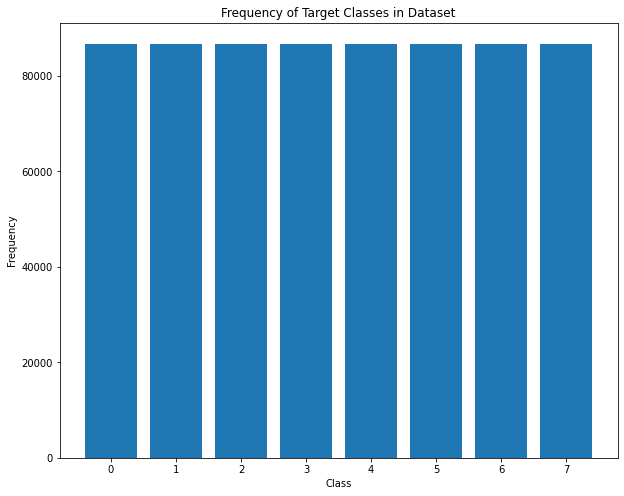

In [90]:
X_smote, y_smote = usm.smote_data(X_train2, y_train2)
usm.display_frequencies(y_smote)

In [134]:
tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
# tree = DecisionTreeClassifier()
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=5)

Training Score: 0.4361530335043767
Testing Score: 0.43391385711267394

 Confusion Matrix


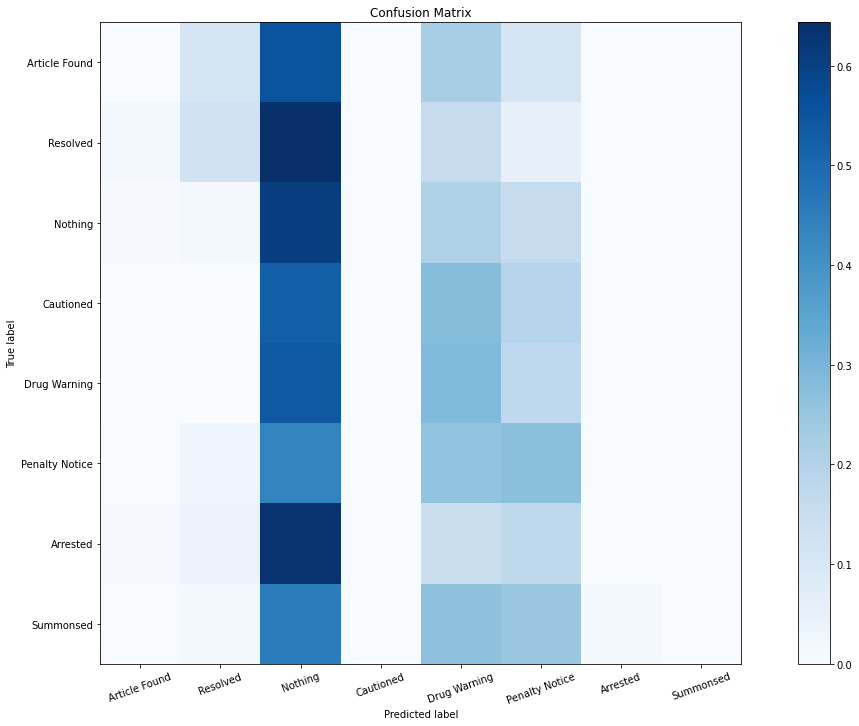

In [135]:
print(f"Training Score: {tree.score(X_train2, y_train2)}")
print(f"Testing Score: {tree.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = tree.predict(X_test2)
util.confusion_plot(y_test=y_test2, y_predictions=y_predictions)

Less balanced confusion matrix despite better accuracy.

## Using Biased SMOTE
We over sample minority classes, but not to an extent that equalizes them to the majority class

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


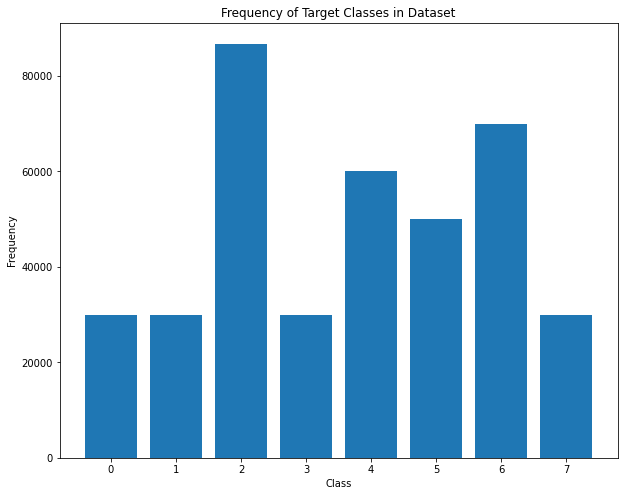

In [83]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train2, y_train2, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [139]:
#tree = DecisionTreeClassifier()
tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree.fit(X_smote, y_smote)

DecisionTreeClassifier(max_depth=5)

Training Score: 0.4361530335043767
Testing Score: 0.43391385711267394

 Confusion Matrix


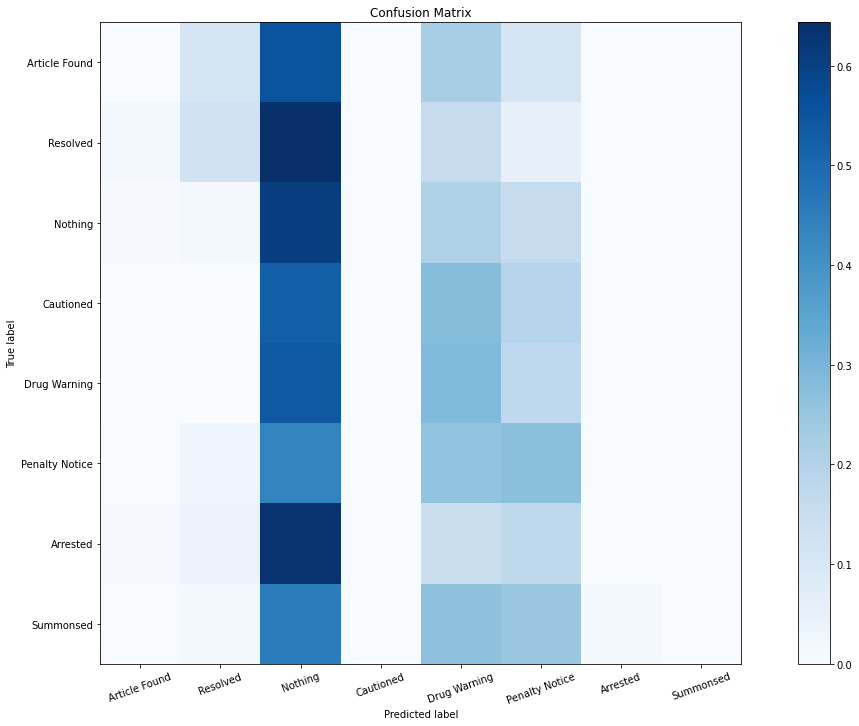

In [143]:
print(f"Training Score: {tree.score(X_train2, y_train2)}")
print(f"Testing Score: {tree.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = tree.predict(X_test2)
util.confusion_plot(y_test=y_test2, y_predictions=y_predictions)

This yields identical confusion matrix and results as without biased SMOTE.

## Bootstrap Aggregating

In [142]:
bagging = BaggingClassifier()
bagging.fit(X_train2, y_train2)

BaggingClassifier()

Training Score: 0.9509055236945366
Testing Score: 0.5843168029941747

 Confusion Matrix


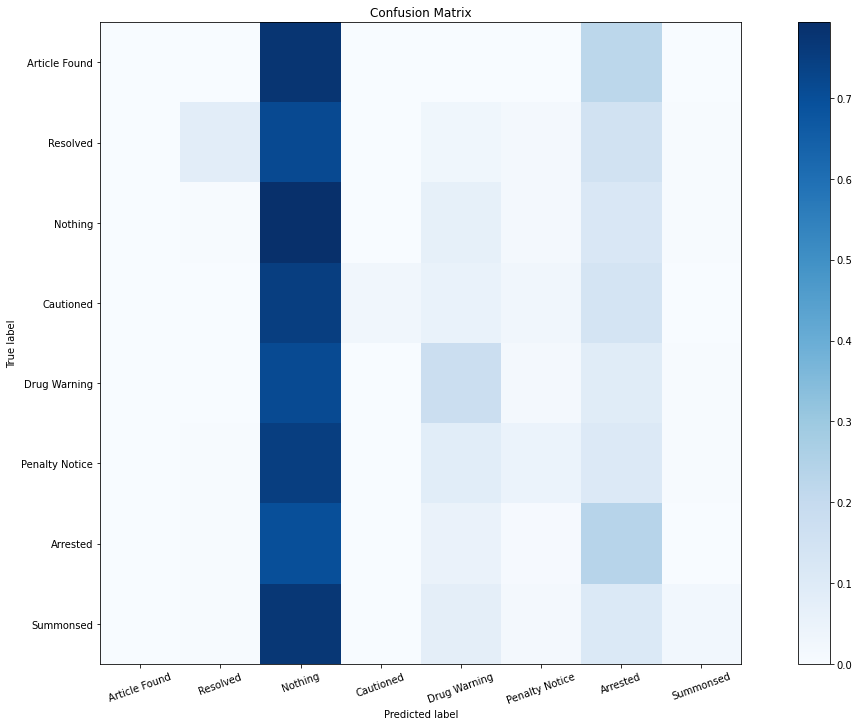

In [108]:
print(f"Training Score: {bagging.score(X_train2, y_train2)}")
print(f"Testing Score: {bagging.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = bagging.predict(X_test2)
util.confusion_plot(y_test=y_test, y_predictions=y_predictions)

Very similar results to the decision tree, rather than pruning and using K-Fold, I will go straight to using the same SMOTE process as I did for the decision tree.

In [98]:
bagging = BaggingClassifier()
bagging.fit(X_smote, y_smote)

BaggingClassifier()

Training Score: 0.3730531240567462
Testing Score: 0.3660318131055507

 Confusion Matrix


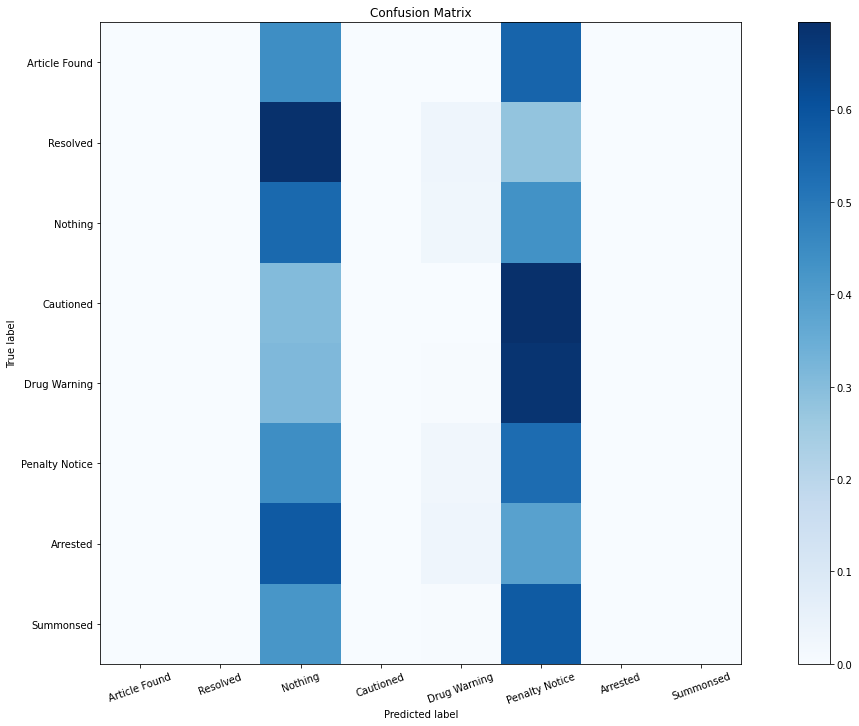

In [136]:
print(f"Training Score: {bagging.score(X_train2, y_train2)}")
print(f"Testing Score: {bagging.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = bagging.predict(X_test2)
util.confusion_plot(y_test=y_test2, y_predictions=y_predictions)

## Using Biased SMOTE

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


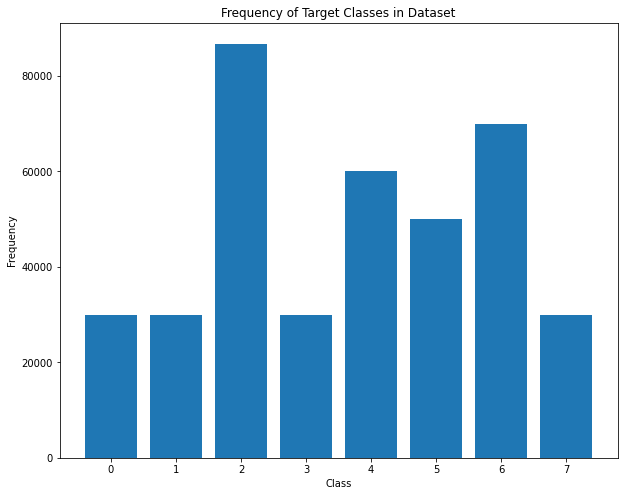

In [100]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train2, y_train2, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [101]:
bagging = BaggingClassifier()
bagging.fit(X_smote, y_smote)

BaggingClassifier()

Training Score: 0.4011092665258074
Testing Score: 0.39636594126346925

 Confusion Matrix


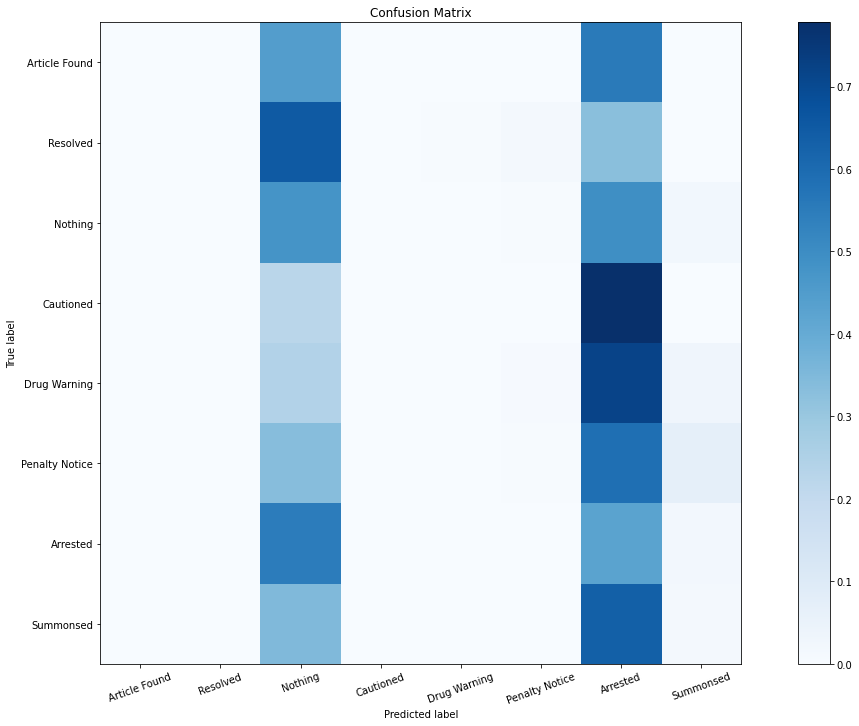

In [146]:
print(f"Training Score: {bagging.score(X_train2, y_train2)}")
print(f"Testing Score: {bagging.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = bagging.predict(X_test2)
util.confusion_plot(y_test=y_test2, y_predictions=y_predictions)

Marginally better than the first SMOTE

## Random Forests

[0.5228939663759017, 0.5834414898433491, 0.5593854698016963, 0.580423168633606, 0.5687422655519, 0.5825058102683287, 0.5723340677914943, 0.5836225891159337, 0.5774953970601552, 0.57978932117956, 0.580634451118288, 0.5807853671787752, 0.5774048474238629, 0.5836225891159337, 0.5809664664513597, 0.5817814131779904, 0.5788536416045396, 0.5818417796021853, 0.5795176722706831, 0.5803628022094112, 0.580000603664242, 0.5810871992997495, 0.5802118861489239, 0.5804533518457035, 0.5803024357852162, 0.5838338716006157, 0.5800911533005343, 0.5817814131779904, 0.5798496876037548, 0.5823548942078416, 0.5792158401497087, 0.5821134285110622, 0.5808759168150675, 0.5817814131779904, 0.5813588482086264, 0.581057016087652, 0.5794573058464881, 0.580423168633606, 0.5803929854215085, 0.5827774591772057, 0.5814493978449187, 0.5807853671787752, 0.5805740846940931, 0.5825661766925236, 0.5812984817844316, 0.5817814131779904, 0.5804533518457035, 0.5811777489360418, 0.5808759168150675, 0.5816304971175033, 0.5806646

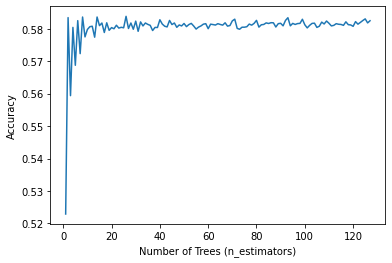

In [168]:
# Investigates the accuracy over a range of estimators plotting the result
# Same function used in exercise 5 part 2
accuracy_data = []
nums = []
for i in range(1,128):
    rf_model = RandomForestClassifier(n_estimators=i,criterion="entropy")
    rf_model.fit(X_train2, y_train2)
    y_model = rf_model.predict(X_test2)
    accuracy = accuracy_score(y_test2, y_model)
    accuracy_data.append(accuracy)
    nums.append(i)
    
print(accuracy_data)
plt.plot(nums,accuracy_data)
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.show()

# rf_model = RandomForestClassifier(n_estimators=10,criterion="entropy")
# rf_model.fit(X_train2, y_train2)

Training Score: 0.9477739209175974
Testing Score: 0.5809966496634572

 Confusion Matrix


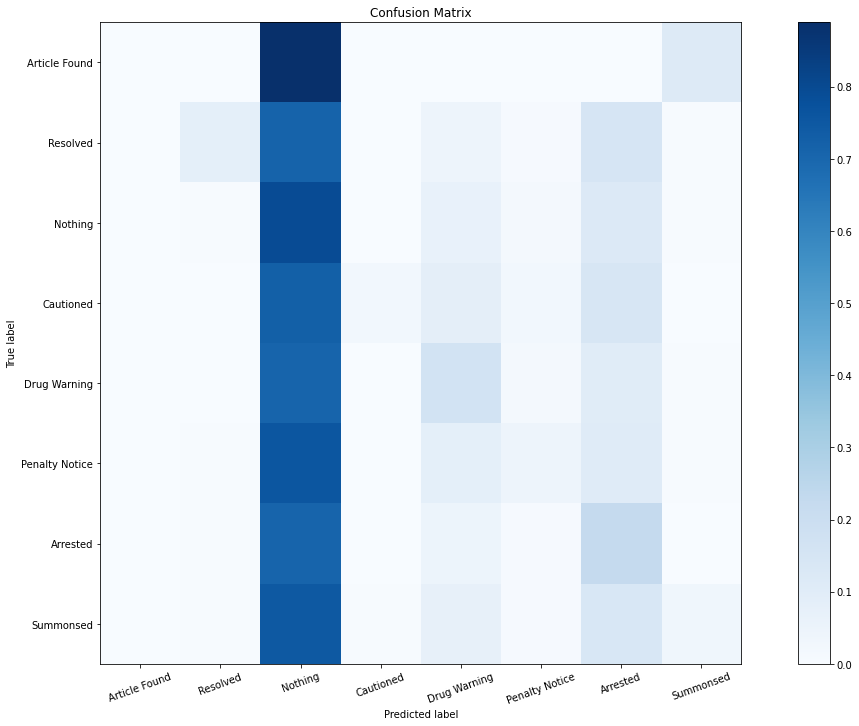

In [161]:
print(f"Training Score: {rf_model.score(X_train2, y_train2)}")
print(f"Testing Score: {rf_model.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = rf_model.predict(X_test2)
util.confusion_plot(y_test=y_test2, y_predictions=y_predictions)

Similarly to Bagging, I shall use SMOTE to reduce the overfitting and balance the confusion matrix.

In [162]:
rf_model = RandomForestClassifier(n_estimators=10,criterion="entropy")
rf_model.fit(X_smote, y_smote)

RandomForestClassifier(criterion='entropy', n_estimators=10)

Training Score: 0.9491925747057048
Testing Score: 0.5085871238417192

 Confusion Matrix


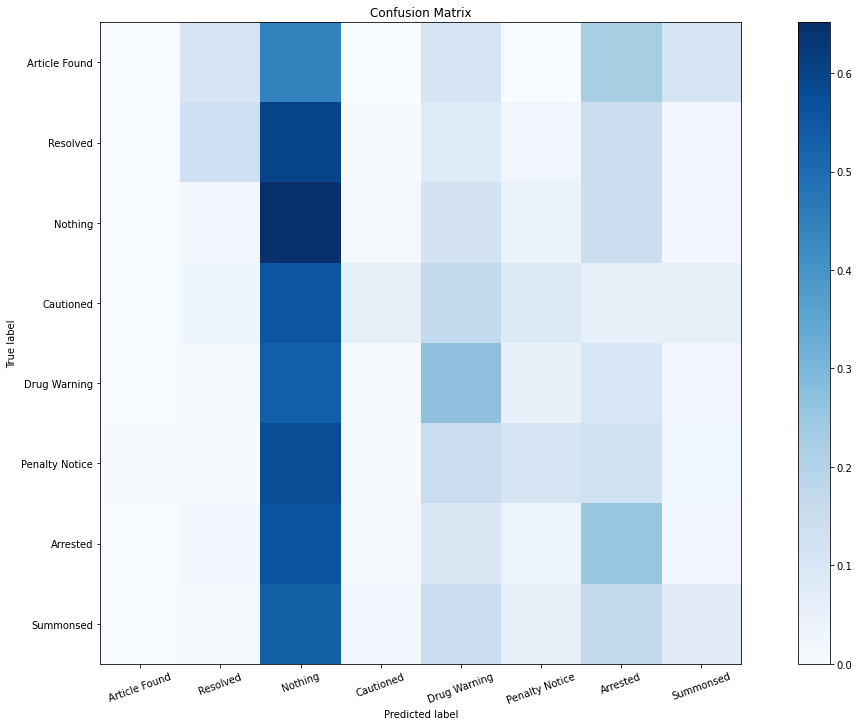

In [163]:
print(f"Training Score: {rf_model.score(X_train2, y_train2)}")
print(f"Testing Score: {rf_model.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = rf_model.predict(X_test2)
util.confusion_plot(y_test=y_test2, y_predictions=y_predictions)

## Using Biased SMOTE

Class 0: 7.76%     (30000)
Class 1: 7.76%     (30000)
Class 2: 22.44%     (86784)
Class 3: 7.76%     (30000)
Class 4: 15.51%     (60000)
Class 5: 12.93%     (50000)
Class 6: 18.1%     (70000)
Class 7: 7.76%     (30000)
Total: 386784


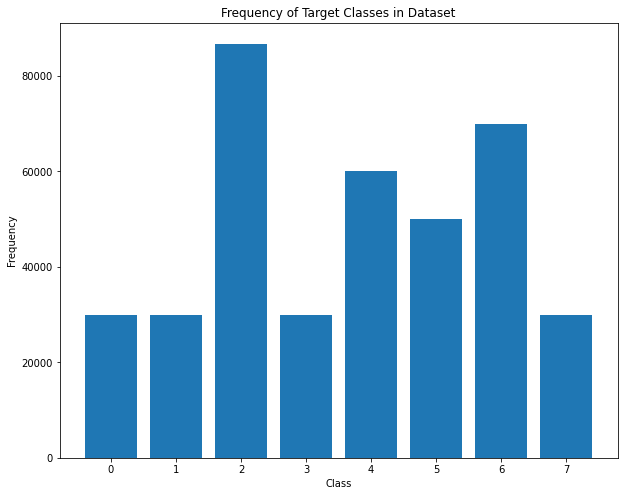

In [164]:
sampling_strategy = {0:30000, 1:30000, 2:86784, 3:30000, 4:60000, 5:50000, 6:70000, 7:30000}
X_smote, y_smote = usm.smote_data(X_train2, y_train2, sampling_strategy=sampling_strategy)
usm.display_frequencies(y_smote)

In [165]:
rf_model = RandomForestClassifier(n_estimators=10,criterion="entropy")
rf_model.fit(X_smote, y_smote)

RandomForestClassifier(criterion='entropy', n_estimators=10)

Training Score: 0.9506112284938123
Testing Score: 0.508013642811868

 Confusion Matrix


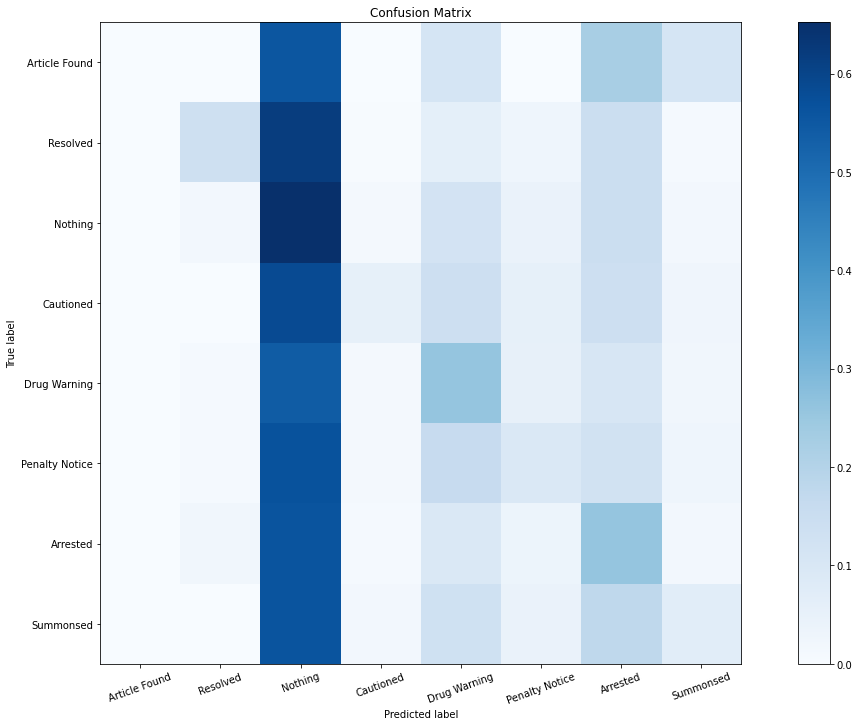

In [166]:
print(f"Training Score: {rf_model.score(X_train2, y_train2)}")
print(f"Testing Score: {rf_model.score(X_test2, y_test2)}")
print("\n Confusion Matrix")
y_predictions = rf_model.predict(X_test2)
util.confusion_plot(y_test=y_test2, y_predictions=y_predictions)